# Load all the required package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import seaborn as sns
import re
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statistics import mean
import random
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.datasets as datasets
import sklearn.metrics as metrics
from numpy import log

Combine all the file and read as csv

In [2]:
def read_organize_data(file_path):
    #file_path: the path to the folder 'data'
    all_data = pd.DataFrame()
    for (path, dirList, fileList) in os.walk(file_path):
        for file in fileList:
            if 'csv' in file:
                curr_data = pd.read_csv(os.path.join(path, file), low_memory=False)
                #Remain columns in original order
                all_data = all_data.append(curr_data, sort=False)  
    return all_data

In [3]:
#data = read_organize_data('data')
#data.to_hdf('./data/listings.hdf', "all")

In [4]:
data = pd.read_hdf('./data/listings.hdf', 'all')

Check the shape of the data and select the predictors that are not words. There are lots of data that contains reviews. We could use them in the future combined with NLP analysis as add-on features.  

In [5]:
data.shape
data.columns
predictors = ['id', 'last_scraped', 'host_total_listings_count', 'host_identity_verified', 'neighbourhood_cleansed',
              'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
              'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'minimum_nights', 'cancellation_policy',
              'is_business_travel_ready', 'cleaning_fee', 'price']
       
predictors_nlp = ['name', 'summary', 'transit', 'interaction', 'host_about']
# amenities can select a few, do seperate cols
# accommodates vs guest_included, extra_people

(298560, 96)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [6]:
data_new = data[predictors]

In [7]:
data_new.dtypes

id                             int64
last_scraped                  object
host_total_listings_count    float64
host_identity_verified        object
neighbourhood_cleansed        object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
square_feet                  float64
minimum_nights                 int64
cancellation_policy           object
is_business_travel_ready      object
cleaning_fee                  object
price                         object
dtype: object

In [8]:
data_new["price"].max()

'$999.00'

In [9]:
# check missing values for each column
data_new.isnull().any()
# check the percentage of NA in each column
data_new.isnull().mean() * 100 
#

id                           False
last_scraped                 False
host_total_listings_count     True
host_identity_verified        True
neighbourhood_cleansed       False
latitude                     False
longitude                    False
property_type                 True
room_type                    False
accommodates                 False
bathrooms                     True
bedrooms                      True
beds                          True
bed_type                     False
amenities                     True
square_feet                   True
minimum_nights               False
cancellation_policy           True
is_business_travel_ready      True
cleaning_fee                  True
price                        False
dtype: bool

id                            0.000000
last_scraped                  0.000000
host_total_listings_count     1.909834
host_identity_verified        1.909834
neighbourhood_cleansed        0.000000
latitude                      0.000000
longitude                     0.000000
property_type                 0.024451
room_type                     0.000000
accommodates                  0.000000
bathrooms                     0.472267
bedrooms                      0.066988
beds                          0.138331
bed_type                      0.000000
amenities                     1.817055
square_feet                  97.706994
minimum_nights                0.000000
cancellation_policy           1.817055
is_business_travel_ready     63.855841
cleaning_fee                 23.929528
price                         0.000000
dtype: float64

# Visualization

0.0      25922
1.0     187733
2.0      51384
3.0      23925
4.0       7560
5.0       1115
6.0        304
7.0        128
8.0         16
9.0         43
10.0        36
11.0         2
15.0       192
Name: bedrooms, dtype: int64

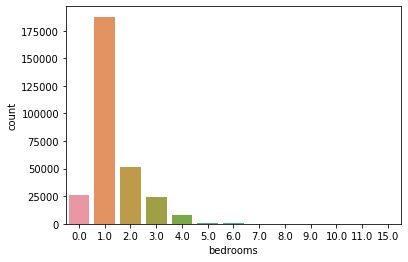

In [10]:
# visualize distribution
sns.countplot(data_new['bedrooms'].dropna())
data_new['bedrooms'].value_counts().sort_index()

0.0       2512
0.5       1166
1.0     214660
1.5      21882
2.0      38794
2.5       7491
3.0       5521
3.5       2117
4.0       1204
4.5        407
5.0        522
5.5         38
6.0        235
6.5         27
7.0        101
7.5          8
8.0        268
9.0          4
10.0         1
15.0       192
Name: bathrooms, dtype: int64

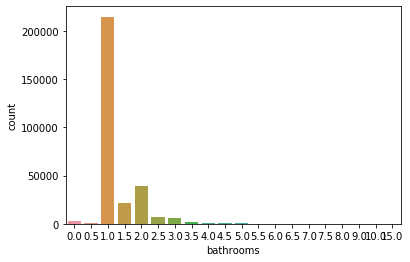

In [11]:
sns.countplot(data_new['bathrooms'].dropna())
data_new['bathrooms'].value_counts().sort_index()

# Data cleaning
## Correlation plot

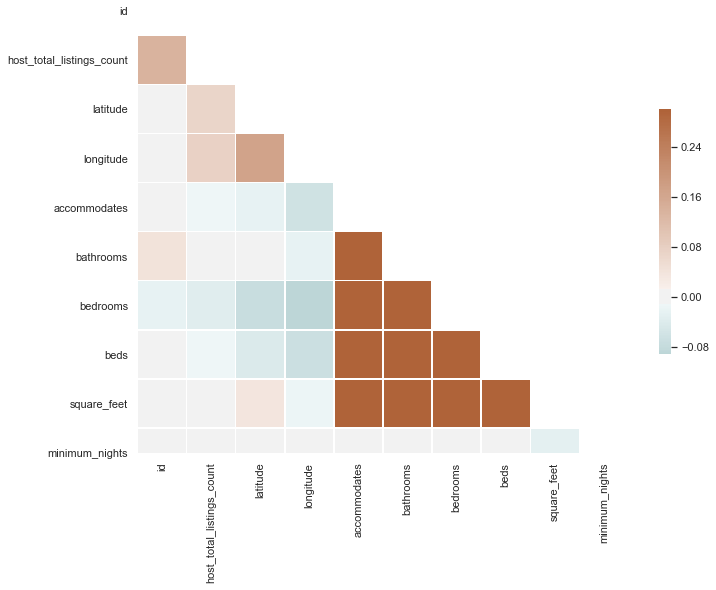

In [12]:
sns.set(style="white")

# Compute the correlation matrix 'top90', 'upto25', .drop(['scrape_id', 'license'], axis=1)
corr = data_new.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(200, 30, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
# def convert_currency(val):
#     new_val = val.replace(',','').replace('$', '') # Remove $ and commas
#     return float(new_val)
def remove_dollar_sign(val):
    new_val = val.replace("$", "")
    new_val = float(new_val)
    return new_val
def remove_commas(val): 
    new_val = val.replace(",", "")
    return new_val

In [14]:
# convert price to numeric
data_new.loc[:,'price'] = data_new.loc[:,'price'].copy().apply(remove_commas).apply(remove_dollar_sign)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Convert cleaning_fee to numeric, remove dollar sign and fill NA with 0

In [15]:
data_new['cleaning_fee'] = pd.to_numeric(data_new['cleaning_fee'].str.strip('$'), errors='coerce').fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Remove outliers

In [16]:
# Since 98% of 'square_feet' are NA, I will drop this column
data_new = data_new.drop('square_feet', axis=1)

In [17]:
def data_distribution(duration):
 
    x = np.array(duration)
    n = len(x)
    n_bins = round(2 * n**(1/3))
    fig = plt.figure()
    plt1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])
    plt1 = plt.hist(x, bins=n_bins, alpha=0.7)
    plt2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
    plt2 = plt.boxplot(x, vert=False, widths=0.7)
    plt.show()

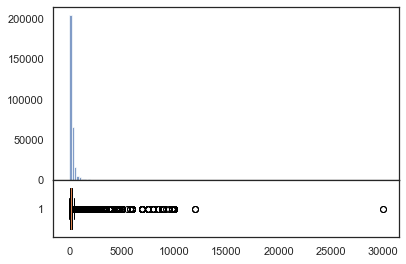

2000.0

In [18]:
data_distribution(data_new['price'])
max_price = np.quantile(data_new['price'], 0.995)
max_price
data_new = data_new.loc[(data_new['price'] <= max_price) & (data_new['price'] > 1), ]

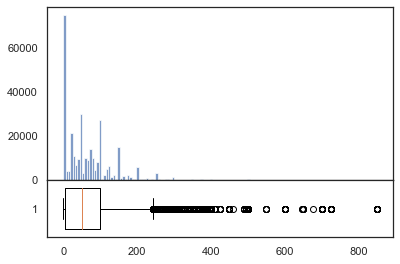

In [19]:
data_distribution(data_new['cleaning_fee'])
max_clean = np.quantile(data_new['cleaning_fee'], 0.99)
data_new = data_new.loc[(data_new['cleaning_fee'] <= max_clean) & (data_new['cleaning_fee'] > 1), ]

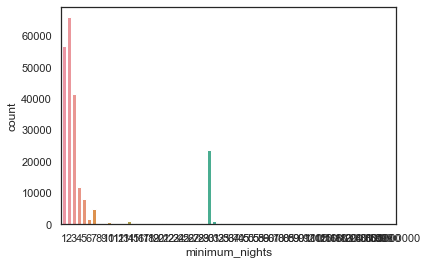

In [20]:
sns.countplot(data_new['minimum_nights'])
data_new = data_new.loc[data_new['minimum_nights'] <= 366, ]

In [21]:
max_listing = np.quantile(data_new['host_total_listings_count'].dropna(), 0.99)
max_listing
data_new = data_new.loc[data_new['host_total_listings_count'] <= max_listing, ]

139.0

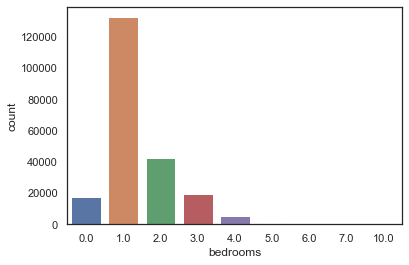

In [22]:
sns.countplot(data_new['bedrooms'])
data_new = data_new.loc[data_new['bathrooms'] <= 10, ]

3.5

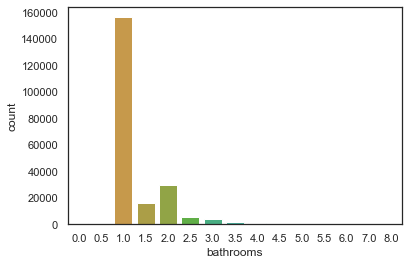

In [23]:
sns.countplot(data_new['bathrooms'])
max_bath = np.quantile(data_new['bathrooms'].dropna(), 0.99)
max_bath
data_new = data_new.loc[data_new['bathrooms'] <= max_bath, ]

12.0

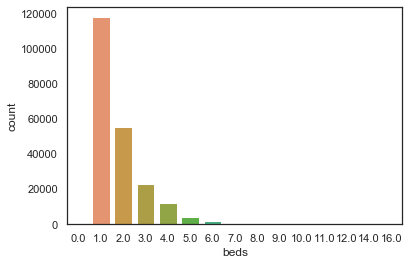

In [24]:
sns.countplot(data_new['beds'])
max_bed = np.quantile(data_new['beds'].dropna(), 0.999)
max_bed
data_new = data_new.loc[data_new['beds'] <= max_bed, ]


In [25]:
data_new['bathrooms'].fillna(int(np.mean(data_new['bathrooms'])), inplace=True)  
data_new['bedrooms'].fillna(int(np.mean(data_new['bedrooms'])), inplace=True) 
data_new['beds'].fillna(int(np.mean(data_new['beds'])), inplace=True)  

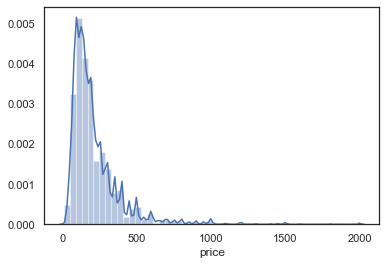

In [26]:
sns.distplot(data_new["price"])

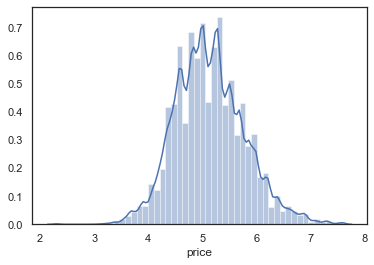

In [27]:
sns.distplot(np.log(data_new["price"]))

In [28]:
data_new.isnull().any()

id                           False
last_scraped                 False
host_total_listings_count    False
host_identity_verified       False
neighbourhood_cleansed       False
latitude                     False
longitude                    False
property_type                 True
room_type                    False
accommodates                 False
bathrooms                    False
bedrooms                     False
beds                         False
bed_type                     False
amenities                    False
minimum_nights               False
cancellation_policy          False
is_business_travel_ready      True
cleaning_fee                 False
price                        False
dtype: bool

In [29]:
data_new = data_new.drop("is_business_travel_ready", axis = 1)

In [30]:
# Check how many missing values in the property type column
sum(data_new["property_type"].isna())

21

In [31]:
#Remove all missing value in property column
data_new = data_new.dropna(subset=['property_type'])


### Now we clean all the missing value

In [32]:
#
data_new.isnull().any()

id                           False
last_scraped                 False
host_total_listings_count    False
host_identity_verified       False
neighbourhood_cleansed       False
latitude                     False
longitude                    False
property_type                False
room_type                    False
accommodates                 False
bathrooms                    False
bedrooms                     False
beds                         False
bed_type                     False
amenities                    False
minimum_nights               False
cancellation_policy          False
cleaning_fee                 False
price                        False
dtype: bool

In [33]:
data = data_new.copy()

In [139]:
data = pd.get_dummies(data=data, columns=['room_type', 'bed_type', 'property_type', 'cancellation_policy', 'host_identity_verified', 
                                          'neighbourhood_cleansed'], dummy_na=True)
data = data.drop(['amenities', 'last_scraped'], axis = 1)

In [150]:
def split_by_id(df, p):
    df_gb_id = data.groupby(['id'])
    ids = df_gb_id.groups.keys()
    ids = list(ids)
    ids = np.array(ids)
    n = len(ids)
    random_index = np.random.choice(n, int(n * p), replace=False)
    test_id = ids[random_index.astype(int)]
    train_id = ids[list(set(np.arange(n)) - set(random_index))]
    df_train = data.loc[df['id'].isin(train_id)]
    df_test = data.loc[df['id'].isin(test_id)]
    return df_train, df_test

In [151]:
data, test = split_by_id(data, 0.2)

In [152]:
train, valid = split_by_id(data, 0.2)

In [153]:
valid_high = valid.loc[valid['price'] > 300]
valid_low = valid.loc[valid['price'] <= 300]

y_valid_high = valid_high["price"]
y_valid_low = valid_low["price"]
X_valid_high = valid_high.drop(['price'], axis = 1)
X_valid_low = valid_low.drop(['price'], axis = 1)

test_high = test.loc[test['price'] > 300]
test_low = test.loc[test['price'] <= 300]

y_test_high = test_high["price"]
y_test_low = test_low["price"]
X_test_high = test_high.drop(['price'], axis = 1)
X_test_low = test_low.drop(['price'], axis = 1)
y_test = test["price"]
X_test = test.drop(['price'], axis = 1)

In [154]:
# split training data into training set and validation set

In [155]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from xgboost import XGBRegressor


In [156]:
y_train = train["price"]
y_valid = valid["price"]
X_train = train.drop(['price'], axis = 1)
X_valid = valid.drop(['price'], axis = 1)

In [157]:

# X = data.copy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Lasso Regression

In [158]:
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_valid,y_valid)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score )
print ( "test score: ", test_score)
print ("number of features used: ", coeff_used)
coef = pd.Series(lasso.coef_, index = X_train.columns)
coef.sort_index()

ValueError: could not convert string to float: 'https://www.airbnb.com/rooms/13883766'

In [190]:
# train neural network regressors
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               28160     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 69,377
Trainable params: 69,377
Non-trainable params: 0
_________________________________________________________________


In [191]:
history = NN_model.fit(X_train, y_train, epochs=8)


Epoch 1/8
137684/137684 [==============================] - 7s 51us/step - loss: 448.4776 - mean_absolute_error: 448.4776
Epoch 2/8
137684/137684 [==============================] - 7s 47us/step - loss: 168.8637 - mean_absolute_error: 168.8637
Epoch 3/8
137684/137684 [==============================] - 7s 48us/step - loss: 210.6308 - mean_absolute_error: 210.6308
Epoch 4/8
137684/137684 [==============================] - 6s 47us/step - loss: 117.1734 - mean_absolute_error: 117.1734
Epoch 5/8
137684/137684 [==============================] - 6s 45us/step - loss: 105.3981 - mean_absolute_error: 105.3981
Epoch 6/8
137684/137684 [==============================] - 7s 48us/step - loss: 105.3950 - mean_absolute_error: 105.3950
Epoch 7/8
137684/137684 [==============================] - 6s 47us/step - loss: 105.3889 - mean_absolute_error: 105.3889
Epoch 8/8
137684/137684 [==============================] - 6s 47us/step - loss: 105.3914 - mean_absolute_error: 105.3914


In [192]:
prediction = NN_model.predict(X_valid, batch_size=None, verbose=0, steps=None)
mean_absolute_error(prediction, y_valid)

100.92362884845285

# Random Forest Regression

In [193]:
from sklearn.datasets import make_regression
base_rf = RandomForestRegressor(max_depth=8, random_state=233, n_estimators=10, criterion='mse')
base_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=233, verbose=0, warm_start=False)

In [194]:
base_train_prediction = base_rf.predict(X_train)
print("base rf training R^2", base_rf.score(X_train, y_train, sample_weight=None))
print("base rf training MAE", mean_absolute_error(base_train_prediction, y_train))

base rf training R^2 0.6967249947820731
base rf training MAE 56.18802832612665


In [195]:
base_valid_prediction = base_rf.predict(X_valid)
print("base rf validation R^2", base_rf.score(X_valid, y_valid, sample_weight=None))
print("base rf validation MAE", mean_absolute_error(base_valid_prediction, y_valid))

base rf validation R^2 0.4935129108120119
base rf validation MAE 63.27259310231554


In [196]:
base_valid_high = base_rf.predict(X_valid_high)
print("base rf validation for prices > 300 R^2", base_rf.score(X_valid_high, y_valid_high, sample_weight=None))
print("base rf validation for prices > 300 MAE", mean_absolute_error(base_valid_high, y_valid_high))

base rf validation for prices > 300 R^2 -0.3235263538396469
base rf validation for prices > 300 MAE 176.9187104380768


In [197]:
base_valid_low = base_rf.predict(X_valid_low)
print("base rf validation for prices <= 300 R^2", base_rf.score(X_valid_low, y_valid_low, sample_weight=None))
print("base rf validation for prices <= 300 MAE", mean_absolute_error(base_valid_low, y_valid_low))

base rf validation for prices <= 300 R^2 0.18475686109224
base rf validation for prices <= 300 MAE 43.03228153730547


In [198]:
feature_importances = pd.DataFrame(base_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:50]

,importance
bedrooms,0.493942
latitude,0.111949
bathrooms,0.102956
cleaning_fee,0.059128
room_type_Entire home/apt,0.047172
longitude,0.037614
accommodates,0.034519
minimum_nights,0.026603
id,0.026408
neighbourhood_cleansed_Inner Sunset,0.008167


In [199]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 400, num = 1)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = []
max_depth.append(None)
# Minimum number of samples required to split a node

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(10, 100, num = 10)]
# min_samples_split = min_samples_leaf * 1.5

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'n_estimators': [400]}


Manually iterate through some hyperparameters

In [200]:
# best_min_mae = 0
# best_min_score = 0
# best_mae = 1000
# best_score = -1
# for i in min_samples_leaf:
#     base_rf = RandomForestRegressor(random_state=233, n_estimators=400, criterion = 'mae', min_samples_leaf = i, min_samples_split = int(i * 1.5))
#     base_rf.fit(X_train, y_train)
#     score =  base_rf.score(X_valid, y_valid, sample_weight=None)
#     mae = mean_absolute_error(base_rf.predict(X_valid), y_valid)
#     if mae < best_mae:
#         best_min_mae = i
#         best_mae = mae
#     if score > best_score:
#         best_min_score = i
#         best_score = score
# print(best_min_score)

# search for best parameter (takes 10 hours )

In [201]:
#rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)


In [202]:
#rf_random.best_params_

# Without feature selection

In [203]:
best_rf= RandomForestRegressor(n_estimators= 500,min_samples_split=30,min_samples_leaf= 20,max_features= 'auto',
                               max_depth= None,bootstrap= True) 
best_rf.fit(X_train, y_train)
best_train_prediction = best_rf.predict(X_train)
print("best rf training R^2", best_rf.score(X_train, y_train, sample_weight=None))
print("best rf training MAE", mean_absolute_error(best_train_prediction, y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

best rf training R^2 0.8731475072731446
best rf training MAE 26.017196468362762


In [204]:
best_valid_prediction = best_rf.predict(X_valid)
print("best rf validation R^2", best_rf.score(X_valid, y_valid, sample_weight=None))
print("best rf validation MAE", mean_absolute_error(best_valid_prediction, y_valid))

best rf validation R^2 0.4994483382236842
best rf validation MAE 61.685649243250516


In [210]:
pre = best_rf.predict(X_train)
mean_absolute_error(pre, y_train)

26.017196468362762

In [211]:
pre = best_rf.predict(X_valid)
mean_absolute_error(pre, y_valid)

61.685649243250516

In [212]:
best_valid_high = best_rf.predict(X_valid_high)
print("base rf validation for prices > 300 R^2", best_rf.score(X_valid_high, y_valid_high, sample_weight=None))
print("base rf validation for prices > 300 MAE", mean_absolute_error(best_valid_high, y_valid_high))

base rf validation for prices > 300 R^2 -0.29309343155716316
base rf validation for prices > 300 MAE 174.5463187439286


In [213]:
best_valid_low = best_rf.predict(X_valid_low)
print("base rf validation for prices <= 300 R^2", best_rf.score(X_valid_low, y_valid_low, sample_weight=None))
print("base rf validation for prices <= 300 MAE", mean_absolute_error(best_valid_low, y_valid_low))

base rf validation for prices <= 300 R^2 0.16254599824645255
base rf validation for prices <= 300 MAE 41.585225509631805


# Features selections

# To prevent bias, we don't use all the features 
## Based on the rf feature selection

In [214]:
X_train_select = X_train[feature_importances[:50].index]
best_rf_select =  RandomForestRegressor(n_estimators= 500,min_samples_split=30,min_samples_leaf= 20,
 max_features= 'auto',
 max_depth= None,
 bootstrap= True)
best_rf_select.fit(X_train_select,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

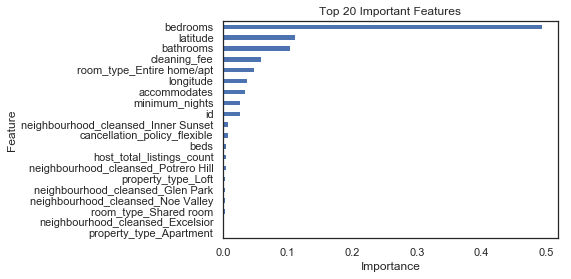

In [215]:
ax = feature_importances.iloc[:20, :].plot(kind='barh',y='importance')
ax.invert_yaxis()
ax.get_legend().remove()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features');

In [216]:
best_train_prediction = best_rf_select.predict(X_train_select)
print("best rf training R^2 with model selection", best_rf_select.score(X_train_select, y_train, sample_weight=None))
print("best rf training MAE with model selection", mean_absolute_error(best_train_prediction, y_train))

best rf training R^2 with model selection 0.8729762115851596
best rf training MAE with model selection 25.972636195282707


In [217]:
X_valid_select = X_valid[feature_importances[:50].index]
best_valid_prediction = best_rf_select.predict(X_valid_select)
print("best rf validation R^2", best_rf_select.score(X_valid_select, y_valid, sample_weight=None))
print("best rf validation MAE", mean_absolute_error(best_valid_prediction, y_valid))

best rf validation R^2 0.4976835732499505
best rf validation MAE 61.72278863763942


In [218]:
best_valid_high = best_rf_select.predict(X_valid_high[feature_importances[:50].index])
print("base rf validation with selection for prices > 300 R^2", best_rf_select.score(X_valid_high[feature_importances[:50].index], y_valid_high, sample_weight=None))
print("base rf validation with selection for prices > 300 MAE", mean_absolute_error(best_valid_high, y_valid_high))

base rf validation with selection for prices > 300 R^2 -0.2984009014828706
base rf validation with selection for prices > 300 MAE 175.02816845509042


In [219]:
best_valid_low = best_rf_select.predict(X_valid_low[feature_importances[:50].index])
print("base rf validation with selection for prices <= 300 R^2", best_rf_select.score(X_valid_low[feature_importances[:50].index], y_valid_low, sample_weight=None))
print("base rf validation with selection for prices <= 300 MAE", mean_absolute_error(best_valid_low, y_valid_low))

base rf validation with selection for prices <= 300 R^2 0.161186665766209
base rf validation with selection for prices <= 300 MAE 41.543162238952384


# XGBRegressor

In [206]:
import xgboost as xgb
model = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_depth=5, min_child_weight=1.5, 
                         n_estimators=1000, reg_alpha=0.75,reg_lambda=0.45,subsample=0.6,seed=42)
model.fit(X_train,y_train)
pre2 = model.predict(X_train)
model.score(X_train, y_train, sample_weight=None)
mean_absolute_error(pre2, y_train)
prediction2 = model.predict(X_valid)
mean_absolute_error(prediction2, y_valid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=5,
       min_child_weight=1.5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6)

0.8842408825116802

36.84705078601491

61.40162093254957

In [207]:
best_train_prediction = model.predict(X_train)
print("best XGBRegressor training R^2", model.score(X_train, y_train, sample_weight=None))
print("best XGBRegressor training MAE", mean_absolute_error(best_train_prediction, y_train))

best_valid_prediction = model.predict(X_valid)
print("best XGBRegressor validation R^2", model.score(X_valid, y_valid, sample_weight=None))
print("best XGBRegressor validation MAE", mean_absolute_error(best_valid_prediction, y_valid))

best_valid_high = model.predict(X_valid_high)
print("base XGBRegressor validation for prices > 300 R^2", model.score(X_valid_high, y_valid_high, sample_weight=None))
print("base XGBRegressor validation for prices > 300 MAE", mean_absolute_error(best_valid_high, y_valid_high))

best_valid_low = model.predict(X_valid_low)
print("base XGBRegressor validation for prices <= 300 R^2", model.score(X_valid_low, y_valid_low, sample_weight=None))
print("base XGBRegressor validation for prices <= 300 MAE", mean_absolute_error(best_valid_low, y_valid_low))

best XGBRegressor training R^2 0.8842408825116802
best XGBRegressor training MAE 36.84705078601491
best XGBRegressor validation R^2 0.5365449629290868
best XGBRegressor validation MAE 61.40162093254957
base XGBRegressor validation for prices > 300 R^2 -0.17060797474041833
base XGBRegressor validation for prices > 300 MAE 168.25583837920973
base XGBRegressor validation for prices <= 300 R^2 0.16787877376487514
base XGBRegressor validation for prices <= 300 MAE 42.37094303648056


# Error metrics on Test set (Random forest)

In [221]:

best_test_prediction = best_rf_select.predict(X_test[feature_importances[:50].index])
print("best random forest test R^2", best_rf_select.score(X_test[feature_importances[:50].index], y_test, sample_weight=None))
print("best random forest test MAE", mean_absolute_error(best_test_prediction, y_test))

best_test_high = best_rf_select.predict(X_test_high[feature_importances[:50].index])
print("base random forest test for prices > 300 R^2", best_rf_select.score(X_test_high[feature_importances[:50].index], y_test_high, sample_weight=None))
print("base random forest test for prices > 300 MAE", mean_absolute_error(best_test_high, y_test_high))

best_test_low = best_rf_select.predict(X_test_low[feature_importances[:50].index])
print("base random forest test for prices <= 300 R^2", best_rf_select.score(X_test_low[feature_importances[:50].index] ,y_test_low, sample_weight=None))
print("base random forest test for prices <= 300 MAE", mean_absolute_error(best_test_low, y_test_low))

best random forest test R^2 0.4715297173457857
best random forest test MAE 66.86678194947744
base random forest test for prices > 300 R^2 -0.3583521504998959
base random forest test for prices > 300 MAE 171.06298642526033
base random forest test for prices <= 300 R^2 -0.200130311517132
base random forest test for prices <= 300 MAE 46.43512755769701


# Time series-- mean price (further things to do in the future)

array(['2018-01-17', '2016-12-03', '2016-12-04', '2015-12-02',
       '2018-04-07', '2018-04-06', '2017-09-02', '2016-02-02',
       '2017-01-01', '2018-03-04', '2018-03-06', '2017-08-02',
       '2018-02-02', '2017-03-02', '2016-05-02', '2018-01-10',
       '2018-11-03', '2017-12-07', '2016-04-03', '2017-02-02',
       '2017-07-02', '2016-09-02', '2017-11-01', '2015-09-02',
       '2016-10-01', '2018-07-05', '2017-10-02', '2016-11-02',
       '2015-11-02', '2015-11-01', '2018-05-09', '2016-08-02',
       '2016-08-03', '2017-06-02', '2017-11-08', '2018-12-06',
       '2018-08-06', '2017-04-02', '2016-06-02', '2016-07-02',
       '2017-05-02', '2017-05-03', '2017-12-02', '2017-12-03',
       '2018-09-08', '2018-10-03'], dtype=object)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 10 Text xticklabel objects>)

Text(0, 0.5, 'price')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Mean price vs time series')

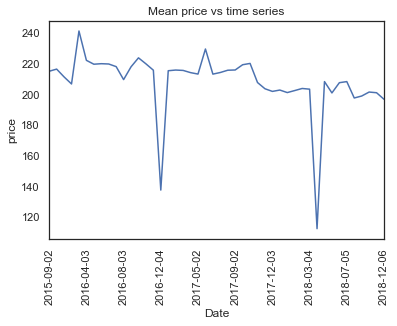

In [209]:
data_new["last_scraped"].unique()

series = data_new.groupby("last_scraped").mean()["price"]
series.plot()
plt.xticks(rotation=90)
plt.ylabel("price")
plt.xlabel("Date")
plt.title("Mean price vs time series")